<h1 align="center"><font size="5">Aadhar Image Mask </font></h1>

In [58]:
# Import the necessary modules
import cv2
import numpy as np
import pytesseract
from pytesseract import Output
import regex as r
import matplotlib.pyplot as plt
from PIL import Image

In [59]:
# Set the categories of Aadhar card
smallcard = "smallcard"
bigcard = "bigcard"
photocopy = "photocopy"

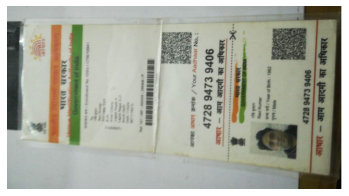

In [60]:
# Display a sample image
plt.imshow(Image.open('img2.jpeg'))
plt.axis("off");

In [65]:
# Load and process the image
def load_process(img, rotate=None):
    image = cv2.imread(img) 
    image = cv2.resize(image, (640,640))

    if rotate==90:
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    elif rotate==180:
        image = cv2.rotate(image, cv2.ROTATE_180_CLOCKWISE)
    elif rotate==270:
        image = cv2.rotate(image, cv2.ROTATE_270_CLOCKWISE)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 90, 150, cv2.THRESH_BINARY)[1]
    return thresh, image

In [66]:
# extract the text from the image using tesseract library
def ocr_img2text(img, rotate=None, category=None):

    thresh, image = load_process(img, rotate)
    
    if category==smallcard:
        d = pytesseract.image_to_data(image, output_type=Output.DICT)
        return d
    
    if category==bigcard:
        d = pytesseract.image_to_data(image, output_type=Output.DICT)
        d1 = pytesseract.image_to_data(thresh, output_type=Output.DICT)
        return d, d1
    
    if category==photocopy:
        d = pytesseract.image_to_data(thresh, output_type=Output.DICT)
        return d

The valid **Aadhar** number must satisfy the following conditions: 

- It should have 12 digits.
- It should not start with 0 and 1.
- It should not contain any alphabet and special characters.
- It should have white space after every 4 digits.
```
regex = “^[2-9]{1}[0-9]{3}\\s[0-9]{4}\\s[0-9]{4}$”
```
Where: 
-   ^ represents the starting of the string.
-  [2-9]{1} represents the first digit should be any from 2-9.
-  [0-9]{3} represents the next 3 digits after the first digit should be any digit from 0-9.
-  \\s represents white space.
-  [0-9]{4} represents the next 4 digits should be any from 0-9.
-  \\s represents white space.
-  [0-9]{4} represents the next 4 digits should be any from 0-9.
-  $ represents the ending of the string.

Click [here](https://www.geeksforgeeks.org/how-to-check-aadhar-number-is-valid-or-not-using-regular-expression/) for more.

In [67]:
# Search for Aadhar number in the detected text using regex search pattern methods
def search_text(img, rotate=None, category=None):
    
    if category == bigcard:
        d, d1 = ocr_img2text(img, rotate, category)
    else:
        d = ocr_img2text(img, rotate, category)
    
    numbers = []
    code = r.compile(r'^[2-9]{1}[0-9]{3}$')
    flag = False
    
    for i, text in enumerate(d['text']):
        result = code.search(d['text'][i])    
        if result :
            if not flag:        
                numbers.append((i, text))
                flag = True
                i = i+1

        if flag:
            code = r.compile(r'^[0-9]{4}$')
            result = code.search(d['text'][i])
            text = d['text'][i]

            if result:
                numbers.append((i, text))
                break
    
    # Useful if aadhar number is present more than once
    # It sets numbers of flags to iterate over the text and matches only
    # the first-two group of 4 digits in a sequence
    if category == bigcard:
        numbers1 = []
        code = r.compile(r'^[2-9]{1}[0-9]{3}$')
        flag1 = True  
        flag2 = False 
        flag3 = False
        counter = 0
        for i in range(len(d1['text'])):
            try:
                if flag3:
                    i= i+2
                result = code.search(d1['text'][i])    
                if result :
                    if flag1:
                        numbers1.append((i, d1['text'][i]))
                        flag2 = True
                        flag1 = False
                        counter += 1
                        #print('1')

                if flag2:
                    code = r.compile(r'^[0-9]{4}$')
                    i = i + 1
                    result = code.search(d1['text'][i])
                    text = d1['text'][i]
                    if result:
                        numbers1.append((i, d1['text'][i]))
                        #print("2")
                        flag1 = True
                        flag2 = False
                        counter += 1
                        flag3 = True
                if counter == 4:
                    break
            except:
                pass
        return numbers, numbers1
    
    return numbers

In [68]:
# Masked the images using the location of the detected text which matched with the pattern
def output(img, rotate=None, category=None, window=None):
    thresh, image = load_process(img, rotate)
    
    if category==bigcard:
        d, d1 = ocr_img2text(img, rotate, category)
    else:
        d = ocr_img2text(img, rotate, category)        
    
    if category == bigcard:
        numbers, numbers1 = search_text(img, rotate, category)
    else:
        numbers = search_text(img, rotate, category)    

    rectangle_list = []
    
    for (i,text) in numbers:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        rectangle_list.append([x, y, w, h])
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
    if category==bigcard:
        for (i,text) in numbers1:
            (x, y, w, h) = (d1['left'][i], d1['top'][i], d1['width'][i], d1['height'][i])
            rectangle_list.append([x, y, w, h])
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    for lt in rectangle_list:
        (x, y, w, h) = lt
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), cv2.FILLED)
    if window=="new":
        cv2.imshow('img', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis("off")

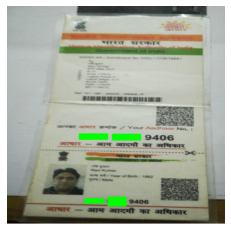

In [69]:
# sample 1
output(img="img2.jpeg", rotate=90, category=bigcard)

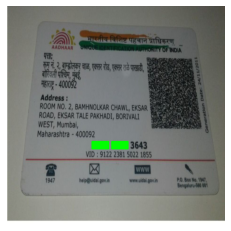

In [70]:
#sample 2
output(img="img1.jpeg",  category=smallcard)

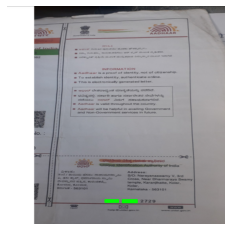

In [74]:
#sample 3
output(img="data/Capture47.png",  category=photocopy)